In [19]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, AveragePooling2D, Dropout, Flatten, Dense, Softmax, Concatenate, MaxPooling2D

import zipfile
import os

**Step 1: Preprocessing Soundtracks & 4Q datasets**

In [22]:
# Assuming 'Set1.zip' is in the current directory
with zipfile.ZipFile('/Users/lindarcourt/Downloads/Set1.zip', 'r') as zip_ref:
    zip_ref.extractall('Set1')

# Now 'Set1' directory contains the unzipped audio files
Soundtracks_dataset_path = 'Set1'

In [23]:
# Load the CSV with ratings
ratings_df = pd.read_csv('/Users/lindarcourt/Downloads/mean_ratings_set1.csv')

In [62]:
def preprocess_audio(file_path, sr=44100, n_mels=128, duration=6):
    try:
        # Load the audio file (supports .mp3 format)
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure the audio length is 6 seconds
        if len(y) < duration * sr:
            padding = duration * sr - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # Short-Time Fourier Transform (STFT) with specified parameters
        stft = librosa.stft(y, n_fft=2048, hop_length=512, window='hann')
        stft_db = librosa.amplitude_to_db(abs(stft))
        
        # Convert STFT to Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=16384)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Adjust the dB scale by adding 20 dB
        mel_spectrogram_db += 20
        
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def get_label_from_filename(filename, ratings_df):
    # Extract the number from the filename
    number = int(filename.split('.')[0].split('_')[-1])
    
    # Find the corresponding row in the DataFrame
    row = ratings_df[ratings_df['number'] == number]
    
    if row.empty:
        raise ValueError(f"No match found in ratings_df for number: {number}")
    
    # Extract valence and arousal
    valence = row['valence'].values[0]
    arousal = row['energy'].values[0]
    
    # Print for debugging
    print(f"Filename: {filename}, Number: {number}, Valence: {valence}, Arousal: {arousal}")
    
    # Determine the quadrant
    if valence > 4 and arousal > 4:
        return 0  # Q1 (exuberance)
    elif valence <= 4 and arousal > 4:
        return 1  # Q2 (anxiety)
    elif valence <= 4 and arousal <= 4:
        return 2  # Q3 (depression)
    elif valence > 4 and arousal <= 4:
        return 3  # Q4 (contentment)
    else:
        raise ValueError("Invalid valence or arousal value")

def load_dataset(dataset_path, ratings_df):
    """
    Load and preprocess dataset.

    Args:
        dataset_path (str): Path to the dataset folder containing audio files.
        ratings_df (DataFrame): DataFrame containing ratings for each file.

    Returns:
        X (list): List of mel spectrograms.
        y (list): List of labels.
    """
    X = []
    y = []

    # Gather all files and sort them numerically
    files = []
    for root, _, filenames in os.walk(dataset_path):
        for file in filenames:
            if file.endswith('.mp3') and not file.startswith('._'):  # Check for .mp3 files and ignore macOS hidden files
                files.append(os.path.join(root, file))
    files.sort(key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

    # Process each file in the sorted order
    for file_path in files:
        mel_spectrogram = preprocess_audio(file_path)
        if mel_spectrogram is not None:
            label = get_label_from_filename(os.path.basename(file_path), ratings_df)  # Use updated label extraction logic
            X.append(mel_spectrogram)
            y.append(label)
    
    return X, y

def plot_mel_spectrogram(mel_spectrogram, sr=22050):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=16384, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB', ticks=[-40, -20, 0, 20])
    plt.title('Mel Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.show()

In [63]:
"""# Load the CSV with ratings
ratings_df = pd.read_csv('/Users/lindarcourt/Downloads/mean_ratings_set1.csv')

# Print the first five rows of the CSV
print(ratings_df.head())"""

# Example usage for the extracted dataset
Soundtracks_dataset_path = 'Set1'
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Confirm labels are correctly assigned
print(y_Soundtracks[:5])



Filename: 001.mp3, Number: 1, Valence: 4.83, Arousal: 6.83
Filename: 002.mp3, Number: 2, Valence: 4.83, Arousal: 6.17
Filename: 003.mp3, Number: 3, Valence: 5.6, Arousal: 6.2
Filename: 004.mp3, Number: 4, Valence: 4.67, Arousal: 6.33
Filename: 005.mp3, Number: 5, Valence: 6.5, Arousal: 5.0
Filename: 006.mp3, Number: 6, Valence: 5.0, Arousal: 5.4
Filename: 007.mp3, Number: 7, Valence: 5.4, Arousal: 6.2
Filename: 008.mp3, Number: 8, Valence: 5.0, Arousal: 5.2
Filename: 009.mp3, Number: 9, Valence: 6.0, Arousal: 6.0
Filename: 010.mp3, Number: 10, Valence: 4.83, Arousal: 6.17
Filename: 011.mp3, Number: 11, Valence: 4.83, Arousal: 6.5
Filename: 012.mp3, Number: 12, Valence: 5.2, Arousal: 6.8
Filename: 013.mp3, Number: 13, Valence: 5.83, Arousal: 5.83
Filename: 014.mp3, Number: 14, Valence: 5.2, Arousal: 6.0
Filename: 015.mp3, Number: 15, Valence: 5.83, Arousal: 4.17
Filename: 016.mp3, Number: 16, Valence: 6.0, Arousal: 3.4
Filename: 017.mp3, Number: 17, Valence: 5.67, Arousal: 4.5
Filename:

Number of samples in X: 360
Number of labels in y: 360
Lengths of X and y match.
Shape of mel spectrogram 0: (128, 517)
Label 0: 3
Shape of mel spectrogram 1: (128, 517)
Label 1: 0
Shape of mel spectrogram 2: (128, 517)
Label 2: 0


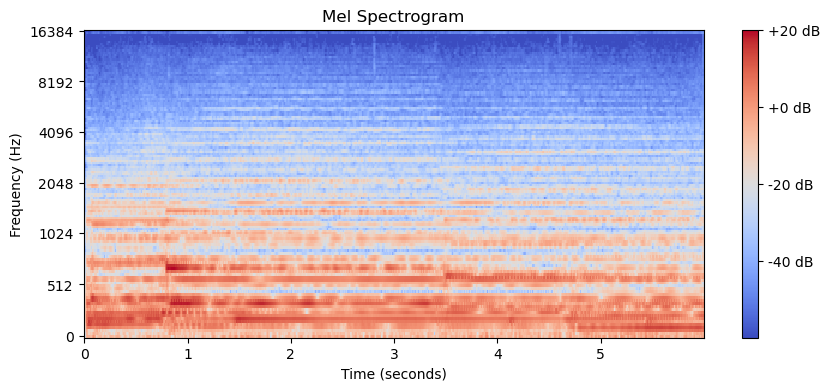

In [41]:
# Check the lengths of X and y
print(f"Number of samples in X: {len(X_Soundtracks)}")
print(f"Number of labels in y: {len(y_Soundtracks)}")

# Ensure that the lengths match
if len(X_Soundtracks) == len(y_Soundtracks):
    print("Lengths of X and y match.")
else:
    print("Mismatch in lengths of X and y.")

# Inspect the shape of the first few mel spectrograms
for i in range(3):
    print(f"Shape of mel spectrogram {i}: {X_Soundtracks[i].shape}")
    print(f"Label {i}: {y_Soundtracks[i]}")


# Test with a sample mel spectrogram
plot_mel_spectrogram(X_Soundtracks[0], sr=44100)

In [ ]:
"""X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path)
X_4q, y_4q = load_dataset(fourq_dataset_path)

# Convert lists to numpy arrays and reshape for the model
X_soundtracks = np.array(X_soundtracks).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary
X_4q = np.array(X_4q).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary"""

**Step 3: Defining model filters**

In [15]:
# Define the fundamental frequencies for each pitch class
pitch_classes = {
    'C': 16.35,
    'C#': 17.32,
    'D': 18.35,
    'D#': 19.45,
    'E': 20.60,
    'F': 21.83,
    'F#': 23.12,
    'G': 24.50,
    'G#': 25.96,
    'A': 27.50,
    'A#': 29.14,
    'B': 30.87
}

def create_pitch_class_blinders(fundamental_freq, filter_type, n_bands):
    frequencies = []
    if filter_type == 'harmonics':
        frequencies = [n * fundamental_freq for n in range(1, n_bands + 1)]
    elif filter_type == 'octaves':
        frequencies = [2**n * fundamental_freq for n in range(n_bands)]
    elif filter_type == 'fifths':
        frequencies = [(3/2)**n * fundamental_freq for n in range(n_bands)]
    else:
        raise ValueError("Unknown filter type")

    # Construct the STFT indicator column
    stft_bins = np.linspace(0, 22050, 1025)  # assuming sampling rate is 44100
    stft_indicator = np.zeros_like(stft_bins)
    
    for freq in frequencies:
        idx = np.argmin(np.abs(stft_bins - freq))
        stft_indicator[idx] = 1
    
    # Convert the STFT indicator column to mel blinders
    mel_bins = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=22050)
    mel_blinders = np.dot(stft_indicator, librosa.filters.mel(sr=44100, n_fft=2048, n_mels=128).T)
    
    return mel_blinders

def create_consonance_filter(input_layer, filter_type, num_bands):
    blinders_list = []
    for pitch, fundamental_freq in pitch_classes.items():
        blinders = create_pitch_class_blinders(fundamental_freq, filter_type, num_bands)
        blinders_list.append(blinders)
    
    blinders_stack = np.stack(blinders_list, axis=-1)
    blinders_tensor = tf.convert_to_tensor(blinders_stack, dtype=tf.float32)
    
    # Expand dimensions to match input layer
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=1)
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=0)
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=-1)  # Add channel dimension
    
    # Apply the mel blinders to the input
    filtered_inputs = []
    for i in range(blinders_tensor.shape[-2]):  # Adjust for pitch class dimension
        filtered_input = tf.multiply(input_layer, blinders_tensor[..., i, :])
        filtered_inputs.append(filtered_input)
    
    # Convolution layer to capture the relevant features
    conv_layers = [Conv2D(32, (128, 1), strides=(1, 1), activation='relu', padding='same')(filtered_input) for filtered_input in filtered_inputs]
    conv_layers = [BatchNormalization()(conv) for conv in conv_layers]
    pooled_layers = [AveragePooling2D(pool_size=(1, 517))(conv) for conv in conv_layers]
    pooled_layers = [Dropout(0.5)(pooled) for pooled in pooled_layers]
    
    return pooled_layers

def create_model_with_consonance_filters(input_shape):
    input_layer = Input(shape=input_shape)

    # Add an extra dimension for the channel
    expanded_input_layer = tf.expand_dims(input_layer, axis=-1)

    # Apply harmonics filter (1400 bands)
    harmonics_outputs = create_consonance_filter(expanded_input_layer, 'harmonics', 1400)

    # Apply octaves filter (11 bands)
    octaves_outputs = create_consonance_filter(expanded_input_layer, 'octaves', 11)

    # Apply fifths filter (20 bands)
    fifths_outputs = create_consonance_filter(expanded_input_layer, 'fifths', 20)

    # Concatenate the outputs of the custom filters
    concatenated = Concatenate()(harmonics_outputs + octaves_outputs + fifths_outputs)

    # Max pooling and further layers as per the article
    x = MaxPooling2D(pool_size=(12, 1))(concatenated)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(32 * 16, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16 * 4, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # 4 quadrants for valence-arousal

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [18]:

input_shape = (128, 517) 
model = create_model_with_consonance_filters(input_shape)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 128, 517)]   0           []                               
                                                                                                  
 tf.expand_dims_5 (TFOpLambda)  (None, 128, 517, 1)  0           ['input_7[0][0]']                
                                                                                                  
 tf.math.multiply_98 (TFOpLambd  (None, 128, 517, 1)  0          ['tf.expand_dims_5[0][0]']       
 a)                                                                                               
                                                                                                  
 tf.math.multiply_99 (TFOpLambd  (None, 128, 517, 1)  0          ['tf.expand_dims_5[0][0]'] 